# Combine basin-scale maps for global dataset
- Include AOU and solubility to the O2 dataset

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import os
from multiprocessing import pool

In [15]:
def set_version(alg,argo,vin):
    version = [f'{alg}.{argo}.1.2.{vin}.4',
         f'{alg}.{argo}.2.2.{vin}.4',
         f'{alg}.{argo}.3.2.{vin}.4',
         f'{alg}.{argo}.4.2.{vin}.4',
         f'{alg}.{argo}.5.2.{vin}.4']
    gver=f'{alg}.{argo}.G.2.{vin}.4'
    return version,gver

In [16]:
os.system('echo $USER > userid')
usrid=np.genfromtxt('userid',dtype='<U16')
os.system('rm userid')
#
diro2=f'/glade/derecho/scratch/{usrid}/ML4O2_results/'
#dirTS='/glade/campaign/univ/ugit0034/EN4/L09_20x180x360/'
dirTS='/glade/campaign/univ/ugit0034/ORAS4/TSN2/'
#endyear=2021
endyear=2018

360 180 38 636
<xarray.DataArray 'depth' (depth: 38)>
array([   5.02159 ,   15.07854 ,   25.16046 ,   35.27829 ,   45.447762,
         55.691494,   66.041985,   76.545914,   87.270287,   98.31118 ,
        109.806175,  121.951897,  135.028549,  149.433731,  165.728455,
        184.697464,  207.425446,  235.386169,  270.534119,  315.374084,
        372.965454,  446.800934,  540.502197,  657.322937,  799.549622,
        967.99585 , 1161.805908, 1378.661011, 1615.290527, 1868.070679,
       2133.51709 , 2408.583496, 2690.780273, 2978.166016, 3269.278076,
       3563.040771, 3858.67627 , 4155.62793 ])
Coordinates:
  * depth    (depth) float64 5.022 15.08 25.16 ... 3.563e+03 3.859e+03 4.156e+03


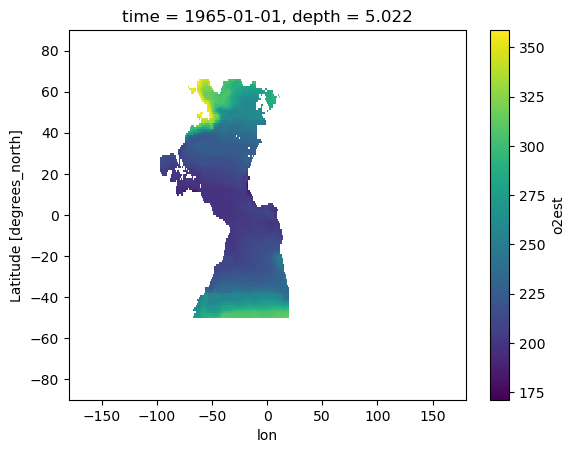

360 180 26 1
<xarray.DataArray 'depth' (depth: 26)>
array([  5.02159 ,  15.07854 ,  25.16046 ,  35.27829 ,  45.44776 ,  55.691494,
        66.041985,  76.54591 ,  87.27029 ,  98.31118 , 109.806175, 121.9519  ,
       135.02855 , 149.43373 , 165.72845 , 184.69746 , 207.42545 , 235.38617 ,
       270.53412 , 315.37408 , 372.96545 , 446.80093 , 540.5022  , 657.32294 ,
       799.5496  , 967.99585 ], dtype=float32)
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 35.28 ... 540.5 657.3 799.5 968.0
Attributes:
    axis:           Z
    standard_name:  depth
    units:          m
    positive:       down
    valid_min:      5.021589756011963
    valid_max:      5350.27197265625


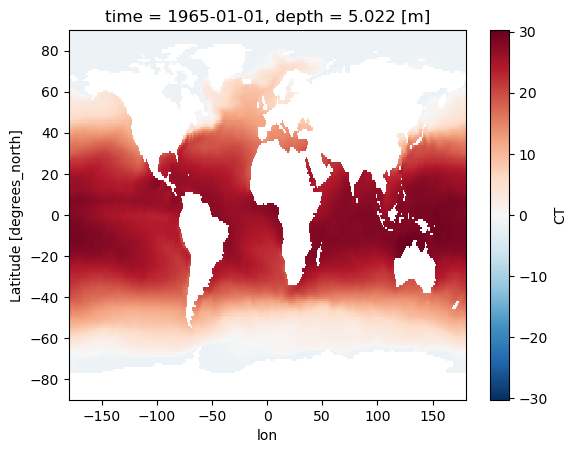

In [4]:
ds=xr.open_dataset(diro2+'O2map_v1.2.1.2.2.4.nc')
x = ds.coords['lon']
y = ds.coords['lat']
z = ds.coords['depth']
t = ds.coords['time'].sel(time=slice('1965-01',f'{endyear-1}-12'))
Nx= np.size(x)
Ny= np.size(y)
Nz= np.size(z)
Nt= np.size(t)
ds.o2est[0,0,:,:].plot()
print(Nx,Ny,Nz,Nt)
print(z)
plt.show()
#
ds=xr.open_dataset(dirTS+'ORAS4_TSN2_196501.nc')
ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
ds = ds.sortby(ds.lon)
x1 = ds.coords['lon']
y1 = ds.coords['lat']
z1 = ds.coords['depth'].sel(depth=slice(0,1000))
t1 = ds.coords['time'].sel(time=slice('1965-01','2014-12'))
Nx1= np.size(x1)
Ny1= np.size(y1)
Nz1= np.size(z1)
Nt1= np.size(t1)
ds.CT[0,0,:,:].plot()
print(Nx1,Ny1,Nz1,Nt1)
print(z1)
plt.show()

In [5]:
year=1999
time=np.arange(f'{year}-01',f'{year+1}-01',dtype='datetime64[M]')
time

array(['1999-01', '1999-02', '1999-03', '1999-04', '1999-05', '1999-06',
       '1999-07', '1999-08', '1999-09', '1999-10', '1999-11', '1999-12'],
      dtype='datetime64[M]')

In [6]:
def calc_o2sat(year):
    fn=f'{dirTS}/ORAS4_TSN2_200101.nc'
    ds=xr.open_dataset(fn)
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    lon=ds.lon#.to_numpy()
    lat=ds.lat#.to_numpy()
    z=ds.depth.sel(depth=slice(0,1000))
    Nx=np.size(x)
    Ny=np.size(y)
    Nz=np.size(z)
    time=np.arange(f'{year}-01',f'{year+1}-01',dtype='datetime64[M]')
    o2s = np.zeros((12,Nz,Ny,Nx))
    for mon in range(12):
        mo=str(mon+1).zfill(2)
        fn=f'{dirTS}/ORAS4_TSN2_{year}{mo}.nc'
        ds=xr.open_dataset(fn)
        ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
        ds = ds.sortby(ds.lon)
        t=ds.CT.sel(depth=slice(0,1000))#.to_numpy()
        s=ds.SA.sel(depth=slice(0,1000))#.to_numpy()
        o2s[mon,:,:,:]=gsw.O2sol(s,t,z,lon,lat)
    #
    da=xr.DataArray(data=o2s,name='o2sol',dims=['time','depth','lat','lon'],
                   coords={'time':time,'depth':z,'lat':lat,'lon':lon})
    ds=da.to_dataset()
    wn=f'{diro2}O2sat_{year}.nc'
    ds.to_netcdf(wn)
    return 1

In [7]:
from multiprocessing import Pool
yrs=np.arange(1965,endyear,1)
if __name__ == '__main__':
    with Pool(10) as p:
        print(p.map(calc_o2sat, yrs))

/glade/derecho/scratch/ito/tmp/ipykernel_12169/464876056.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da=xr.DataArray(data=o2s,name='o2sol',dims=['time','depth','lat','lon'],
/glade/derecho/scratch/ito/tmp/ipykernel_12169/464876056.py:24: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArr

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [8]:
def calc_aou(dsin):
    #time = dsin.time.to_numpy()
    time = dsin.time
    Nt=np.size(time)
    aou=np.zeros((Nt,Nz1,180,360))
    ds=xr.open_mfdataset(f'{diro2}O2sat_*.nc')
    #aou = ds.o2sol.to_numpy() - dsin.o2.interp(depth=z1).to_numpy()
    aou = ds.o2sol.to_numpy() - dsin.o2.to_numpy()
    p=ds.depth#.to_numpy()
    lon=ds.lon#.to_numpy()
    lat=ds.lat#.to_numpy()
    da=xr.DataArray(data=aou,name='aou',
                    dims=['time','depth','lat','lon'],
                    coords={'time':time,'depth':p,'lat':lat,'lon':lon})
    dsin['aou']=da
    return dsin

In [11]:
for alg in [1]:
    for argo in [2]:
        for vin in [2]:
            version,gver = set_version(alg,argo,vin)
            print(gver)
            tmp = np.zeros((5,Nt,Nz1,Ny,Nx))
            for n,ver in enumerate(version):
                print(ver)
                fn=f'{diro2}O2map_v{ver}.nc'
                ds=xr.open_dataset(fn)
                #tmp[n,:,:,:,:] = ds.o2est.sel(time=slice('1965-01',f'{endyear-1}-12')).interp(depth=z1).to_numpy()
                tmp[n,:,:,:,:] = ds.o2est.sel(depth=slice(0,1000)).to_numpy()
            #
            o2=np.nanmean(tmp,axis=0)
            #da=xr.DataArray(data=o2,name='o2',dims=['time','depth','lat','lon'],coords={'time':ds.time.sel(time=slice('1965-01',f'{endyear-1}-12')),'depth':ds.depth.interp(depth=z1),'lat':ds.lat,'lon':ds.lon})
            da=xr.DataArray(data=o2,name='o2',dims=['time','depth','lat','lon'],coords={'time':ds.time,'depth':z1,'lat':ds.lat,'lon':ds.lon})
            ds=da.to_dataset()
            ds1=calc_aou(ds)
            ds1.to_netcdf(diro2+f'O2map_v{gver}.nc')

1.2.G.2.2.4
1.2.1.2.2.4
1.2.2.2.2.4
1.2.3.2.2.4
1.2.4.2.2.4
1.2.5.2.2.4


/glade/derecho/scratch/ito/tmp/ipykernel_12169/1180403397.py:14: RuntimeWarning: Mean of empty slice
  o2=np.nanmean(tmp,axis=0)


In [12]:
ds1

<xarray.Dataset>
Dimensions:  (time: 636, depth: 26, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1965-01-01 1965-02-01 ... 2017-12-01
  * depth    (depth) float32 5.022 15.08 25.16 35.28 ... 540.5 657.3 799.5 968.0
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    o2       (time, depth, lat, lon) float64 nan nan nan ... 299.9 299.9 299.9
    aou      (time, depth, lat, lon) float64 nan nan nan ... 50.09 50.09 50.09